In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from itertools import product
from functools import reduce

In [2]:
# define labels
MUST_HAVE_LABELS = ('endemic', 'non_case')
DATA_LABELS = ('one', 'two', 'three') + MUST_HAVE_LABELS

In [3]:
# define coordinate system
df = pd.concat([pd.DataFrame(columns=["x1", "x2"], data=product(range(5), range(5))), 
     pd.DataFrame(columns=DATA_LABELS)])

In [4]:
df.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,NaN,NaN,NaN,NaN,NaN


In [5]:
# read in data
one = [0] * 5 + [0, 1, 1, 0, 0] + [0, 0, 1, 0, 0] + [0] * 10
two = [0, 0, 1, 1, 1,] + [0] * 10 + [0, 0, 0, 1, 0] + [0] * 5
three = [0] * 15 + [0, 0, 0, 1, 2] + [0] * 5
endemic = (
    [0] * 5 + [1, 0, 0, 0, 0] + [0, 1, 0, 0, 0] + [4, 0, 0, 0, 1] + [2, 0, 0, 0, 1]
)

df_structured_data = df.assign(one=one, two=two, three=three, endemic=endemic)

In [6]:
df_structured_data.head()

,x1,x2,one,two,three,endemic,non_case
0,0.0,0.0,0,0,0,0,NaN
1,0.0,1.0,0,0,0,0,NaN
2,0.0,2.0,0,1,0,0,NaN
3,0.0,3.0,0,1,0,0,NaN
4,0.0,4.0,0,1,0,0,NaN


In [7]:
# pad dummy-non-cases
no_assigned_label = df_structured_data.loc[:, [label for label in DATA_LABELS if label!="non-case"]].sum(axis=1) == 0
df_padded = df_structured_data.assign(non_case=lambda x: x.loc[:, ["non_case"]].mask(no_assigned_label, 1).fillna(0))

In [8]:
df_padded.tail()

,x1,x2,one,two,three,endemic,non_case
20,4.0,0.0,0,0,0,2,0
21,4.0,1.0,0,0,0,0,1
22,4.0,2.0,0,0,0,0,1
23,4.0,3.0,0,0,0,0,1
24,4.0,4.0,0,0,0,1,0


In [9]:
# calculate disease probability per cell
df_padded.loc[:, DATA_LABELS] = df_padded.loc[:, DATA_LABELS].div(df_padded.loc[:, DATA_LABELS].sum(axis=1), axis=0)

In [10]:
df_padded.tail()

,x1,x2,one,two,three,endemic,non_case
20,4.0,0.0,0.0,0.0,0.0,1.0,0.0
21,4.0,1.0,0.0,0.0,0.0,0.0,1.0
22,4.0,2.0,0.0,0.0,0.0,0.0,1.0
23,4.0,3.0,0.0,0.0,0.0,0.0,1.0
24,4.0,4.0,0.0,0.0,0.0,1.0,0.0


In [11]:
def run_algo_A(df_structured_data):
    assert len(df_structured_data) == 25
    signale = pd.DataFrame({"x1": [1,1,2,2,3,4], "x2": [1,2,1,2,0,0], "w_A": [1,1,1,1,0.5,0.5]})
    signale = df_structured_data.loc[:, ["x1", "x2"]].merge(signale, how="left", on=["x1", "x2"])
    return signale.fillna(0)

In [12]:
def run_algo_B(df_structured_data):
    assert len(df_structured_data) == 25
    signale = pd.DataFrame({"x1": [2,2,2,3,3,3,4,4,4], "x2": [2,3,4,2,3,4,2,3,4], "w_B": [0.5]*9})
    signale = df_structured_data.loc[:, ["x1", "x2"]].merge(signale, how="left", on=["x1", "x2"])
    return signale.fillna(0)

In [13]:
def run_algo_C(df_structured_data):
    assert len(df_structured_data) == 25
    signale = pd.DataFrame({"x1": [0], "x2": [4], "w_C": [1]})
    signale = df_structured_data.loc[:, ["x1", "x2"]].merge(signale, how="left", on=["x1", "x2"])
    return signale.fillna(0)

In [14]:
# create signals
signal_A = run_algo_A(df_structured_data)
signal_B = run_algo_B(df_structured_data)
signal_C = run_algo_C(df_structured_data)

signals_without_endemic_non_case = reduce(lambda l, r: pd.merge(l,r, on=["x1", "x2"]), [signal_A, signal_B, signal_C, df_padded])

signals_without_endemic_non_case.head()

,x1,x2,w_A,w_B,w_C,one,two,three,endemic,non_case
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [17]:
assert signals_without_endemic_non_case.query("non_case==1").loc[:, ["one", "two", "three", "endemic"]].sum().sum() == 0

assert not any((signals_without_endemic_non_case.endemic >0) & (signals_without_endemic_non_case.non_case >0))

In [18]:
# calculate signal for endemic and non-case when not given by algo
signal_columns = [c for c in signals_without_endemic_non_case.columns if "w_" in c]

signals_with_endemic_non_case = signals_without_endemic_non_case.copy()
for signal_column in signal_columns:
    signals_with_endemic_non_case.loc[:, signal_column+"_endemic"] = (1 - signals_with_endemic_non_case.loc[:, signal_column]) * (signals_with_endemic_non_case["endemic"] > 0)
    signals_with_endemic_non_case.loc[:, signal_column+"_non_case"] = (1 - signals_with_endemic_non_case.loc[:, signal_column]) * (signals_with_endemic_non_case["non_case"] > 0)

non_case_signals = signals_with_endemic_non_case.columns[signals_with_endemic_non_case.columns.str.contains(r"w_._non_case")]
endemic_signals = signals_with_endemic_non_case.columns[signals_with_endemic_non_case.columns.str.contains(r"w_._endemic")]

signals_with_endemic_non_case.loc[:, "w_non_case_min"] = signals_with_endemic_non_case[non_case_signals].min(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_min"] = signals_with_endemic_non_case[endemic_signals].min(axis=1)

signals_with_endemic_non_case.loc[:, "w_non_case_max"] = signals_with_endemic_non_case[non_case_signals].max(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_max"] = signals_with_endemic_non_case[endemic_signals].max(axis=1)

signals_with_endemic_non_case.loc[:, "w_non_case_mean"] = signals_with_endemic_non_case[non_case_signals].mean(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_mean"] = signals_with_endemic_non_case[endemic_signals].mean(axis=1)

signals_with_endemic_non_case.loc[:, "w_non_case_median"] = signals_with_endemic_non_case[non_case_signals].median(axis=1)
signals_with_endemic_non_case.loc[:, "w_endemic_median"] = signals_with_endemic_non_case[endemic_signals].median(axis=1)

In [19]:
def transform_for_heatmap(array):
    return np.flip(np.flip(array.reshape((5,-1))), 1)

def plot_heatmap(array, title):
    transformed_array = transform_for_heatmap(array)
    ax = sns.heatmap(transformed_array, linewidth=2, cmap="RdPu", cbar=False, annot=True)
    ax.add_patch(Rectangle((1,2), 2, 2, fill=False, edgecolor='blue', lw=3))
    ax.add_patch(Rectangle((3,4), 2, 1, fill=False, edgecolor='blue',alpha=0.6, lw=3))
    ax.add_patch(Rectangle((2,0), 3, 3, fill=False, edgecolor='orange',alpha=0.6, lw=3))
    ax.add_patch(Rectangle((0,0), 1, 1, fill=False, edgecolor='green', lw=3))
    ax.set_title(title)
    return ax

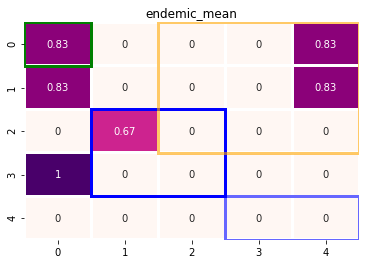

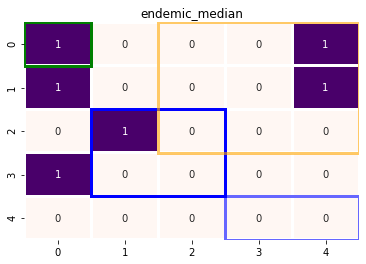

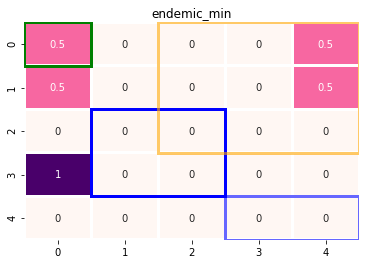

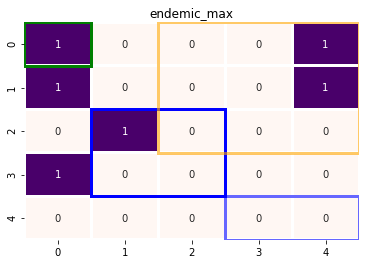

In [20]:
plot_heatmap(signals_with_endemic_non_case.w_endemic_mean.values, "endemic_mean")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_endemic_median.values, "endemic_median")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_endemic_min.values, "endemic_min")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_endemic_max.values, "endemic_max")
plt.show()

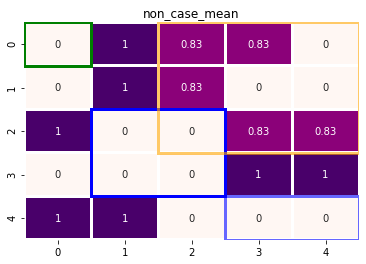

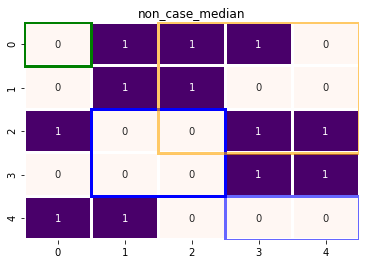

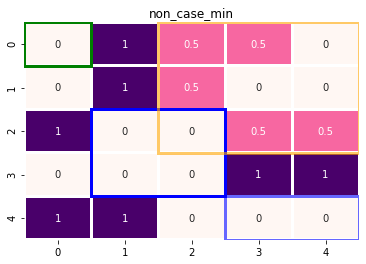

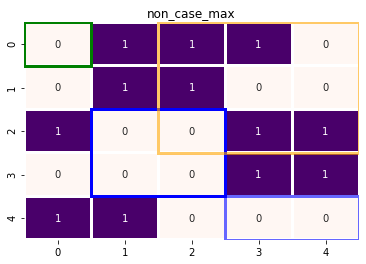

In [21]:
plot_heatmap(signals_with_endemic_non_case.w_non_case_mean.values, "non_case_mean")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_non_case_median.values, "non_case_median")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_non_case_min.values, "non_case_min")
plt.show()
plot_heatmap(signals_with_endemic_non_case.w_non_case_max.values, "non_case_max")
plt.show()